# **Data Visualisation Notebook**

## Objectives

* Answer Business Requirement:
    - The client is interested in conducting a study to visually differentiate a healthy cherry leaf from one with powdery mildew.

## Inputs

* /workspace/mildew-detection-in-cherry-leaves/inputs/datasets/raw/cherry-leaves/train
* /workspace/mildew-detection-in-cherry-leaves/inputs/datasets/raw/cherry-leaves/validation
* /workspace/mildew-detection-in-cherry-leaves/inputs/datasets/raw/cherry-leaves/test

## Outputs

* Compute average image size from the train set. As input size determines the CNN architecture it is important for all input images to be the same size.
* Image shape embedded in a .pkl file.
* Plot mean and variability of images per label plot.
* Plot to distinguish the contrast between healthy cherry leaves and those infected with powdery mildew.
* Code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard. 

## Comments | Insights | Conclusions

* These steps are necessary to further understand and prepare the data before it is provided for the CNN.
* Data will be visually arranged as requested by the client.



---

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style('white')
from matplotlib.image import imread

### Set working directory

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detection-in-cherry-leaves'

### Set input directories

Set train, validation and test file paths.

In [5]:
my_data_dir = 'inputs/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

### Set output directory

In [6]:
version = 'v5'
file_path = os.path.join('outputs', version)

if 'outputs' in os.listdir(work_dir) and version in os.listdir(os.path.join(work_dir, 'outputs')):
    print('Old version is already available. Create a new version')
    pass
else:
    os.makedirs(name=file_path)

### Set label names

In [7]:
labels = os.listdir(train_path)
print('Labels for the images are', labels)

Labels for the images are ['healthy', 'powdery_mildew']


---

# Visualisation of the Image Data

---

### Image Shape

Compute the average image sizes on the 'train' set.

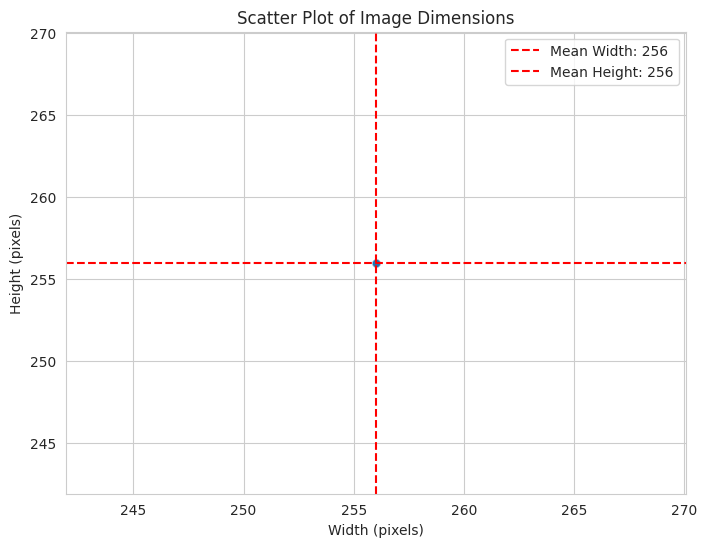

Width average: 256 
Height average: 256


In [8]:
dim1, dim2 = [], []
for label in labels:
    label_path = os.path.join(train_path, label)
    for image_filename in os.listdir(label_path):
        image_path = os.path.join(label_path, image_filename)
        try:
            img = imread(image_path)
            d1, d2, _ = img.shape
            dim1.append(d1) # image height
            dim2.append(d2) # image width
        except Exception as e:
            print(f"Error reading {image_path}: {e}")

# Create a Scatterplot
sns.set_style("whitegrid")
fig, axes = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)

# Labeling axes and adding title
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
axes.set_title("Scatter Plot of Image Dimensions")

# Calculating mean dimensions
dim1_mean = int(np.mean(dim1))
dim2_mean = int(np.mean(dim2))

# Plotting mean lines (corrected labels)
axes.axvline(x=dim2_mean, color='r', linestyle='--', label=f'Mean Width: {dim2_mean}')
axes.axhline(y=dim1_mean, color='r', linestyle='--', label=f'Mean Height: {dim1_mean}')

# Display legend and show the plot
axes.legend()
plt.show()

# Display mean width and height
print(f'Width average: {dim2_mean} \nHeight average: {dim1_mean}')

All images contained in the dataset are the same size - 256 x 256 pixels.
Now, reduce the dimensions in order to increase speed of model training.

In [9]:
image_shape = (int(dim1_mean/2), int(dim2_mean/2), 3)
image_shape

(128, 128, 3)

### Save the image shape embeddings

In [10]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v5/image_shape.pkl']

---

## Average and variability of images per label

### Function to load images into an array (tensor)

In [11]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):
    X, y = [], []
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        image_filenames = os.listdir(os.path.join(my_data_dir, label))  # List images in the label folder

        for image_filename in image_filenames:
            if counter < n_images_per_label:
                img_path = os.path.join(my_data_dir, label, image_filename)
                img = image.load_img(img_path, target_size=new_size)
                img_array = image.img_to_array(img) / 255.0  # Normalize the image
                
                X.append(img_array)  # Append the image array to the list
                y.append(label)  # Append the label to the list
                counter += 1
    
    X = np.array(X)  # Convert list to array
    y = np.array(y)  # Convert list to array
    
    return X, y

### Load image shapes and labels in an array

In [12]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 128, 128, 3) (60,)


### Plot and save mean and variability of images per label

In [13]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label healthy ====
Image Shape: (128, 128, 3)
==== Label powdery_mildew ====
Image Shape: (128, 128, 3)


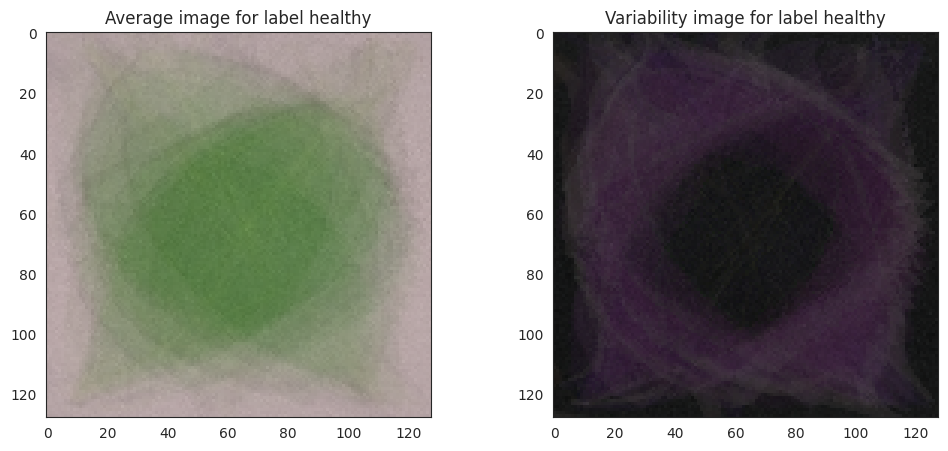

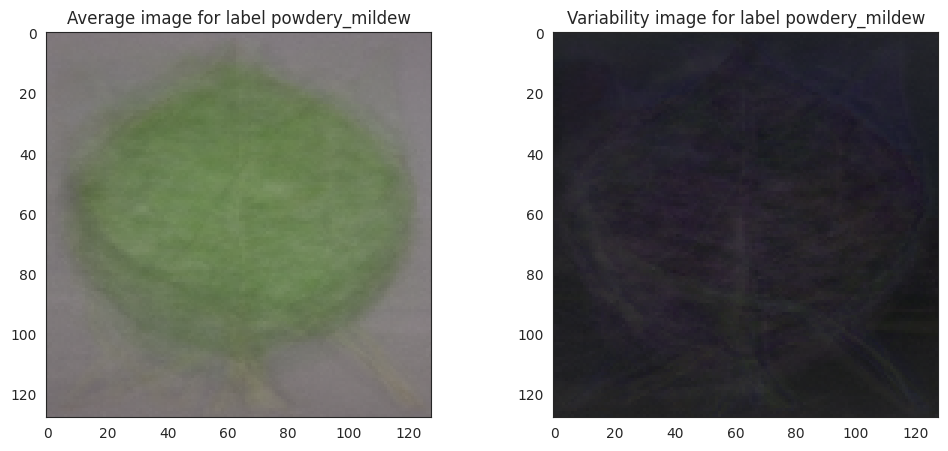

In [14]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

---

### Difference between average powdery mildew infected and average healthy cherry leaves

In [15]:
def subset_image_label(X, y, label_to_display):
    """
    Subsets the image array X by selecting only the layers with the specified label.

    Args:
        X: Array of images
        y: Array of labels, reshaped into a column.
        label_to_display: The label to filter images by.
    
    Returns:
        Array of images with specified label.
    """
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]

    if df.size == 0:
        print(f"No images found for label {label_to_display}")
    return df

def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False, cmap='gray'):
    """
    Calculates the average images for two different labels and plots their averages and the difference.

    Args:
        X: Array of images.
        y: Array of labels.
        label_1: First label for comparison.
        label_2: Second label for comparison.
        figsize: Size of the figure for plotting.
        save_image: Whether to save the image.
        file_path: Path to save the image if `save_image` is True.
        cmap: Colormap for the images.

    Returns:
        None
    """
    sns.set_style("white")

    # Check if label exist in y
    unique_labels = np.unique(y)
    if label_1 not in unique_labels or label_2 not in unique_labels:
        print(
            f"Either label {label_1} or label {label_2}, are not in {unique_labels}")
        return
    
    # calculate mean from label_1
    images_label1 = subset_image_label(X, y, label_1)
    if images_label1.size == 0:
        print(f"No images found for label {label_1}")
        return
    label1_avg = np.mean(images_label1, axis=0)

    # calculate mean from label_2
    images_label2 = subset_image_label(X, y, label_2)
    if images_label2.size == 0:
        print(f"No images found for label {label_2}")
        return
    label2_avg = np.mean(images_label2, axis=0)

    # Calculate and plot the difference between the averages
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap=cmap)
    axes[0].set_title(f"Average {label_1}")
    axes[1].imshow(label2_avg, cmap=cmap)
    axes[1].set_title(f"Average {label_2}")
    axes[2].imshow(difference_mean, cmap=cmap)
    axes[2].set_title(f"Difference image: Avg {label_1} & {label_2}")

    # Save or show the plot
    if save_image:
        if file_path is None:
            print(f"file_path is not specified. Unable to save the image.")
        else:
            plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


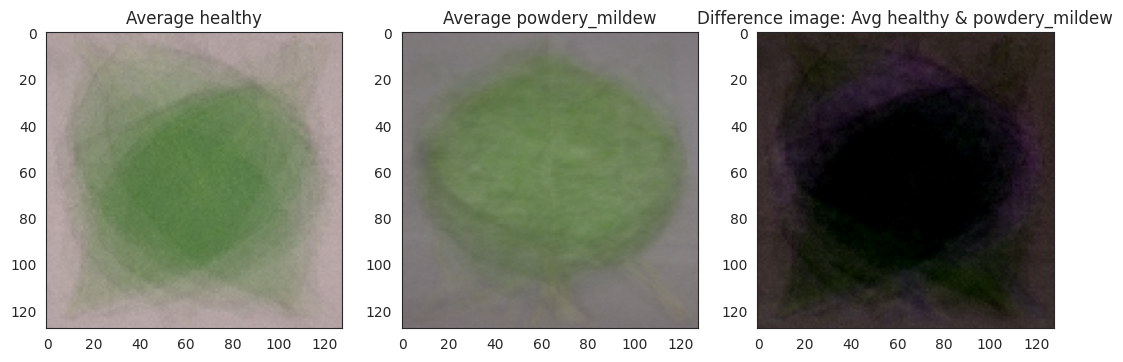

In [16]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(13, 5),
                                        save_image=True
                                        )

---

### Image Montage

In [17]:
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10), cmap=None):
    """
    Displays a montage of images from a specific label in a directory.

    Args:
        dir_path (str): Path to the directory containing the labeled folders of images.
        label_to_display (str): The label (folder name) to display the images from.
        nrows (int): Number of rows in the montage.
        ncols (int): Number of columns in the montage. 
        figsize (tuple): Size of the enture figure.
        cmap (str): Optional colormap for displaying grayscale images.
    
    Returns:
        Displays the image montage or prints an error message if the label or image subset conditions are not met.
    """

    labels = os.listdir(dir_path)
    if label_to_display not in labels:
        print(f"The label {label_to_display} does not exist.")
        print(f"Availalble labels are: {', '.join(labels)}")
        return

    # subset the class you are interested in displaying
    if label_to_display in labels:

        # check if montage space is greater than the subset size
        images_list = os.listdir(os.path.join(dir_path, label_to_display))
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return
        
        # Create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # Create a figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(os.path.join(dir_path, label_to_display, img_idx[x]))
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()
    
    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")

### Run Montage in all Labels

healthy


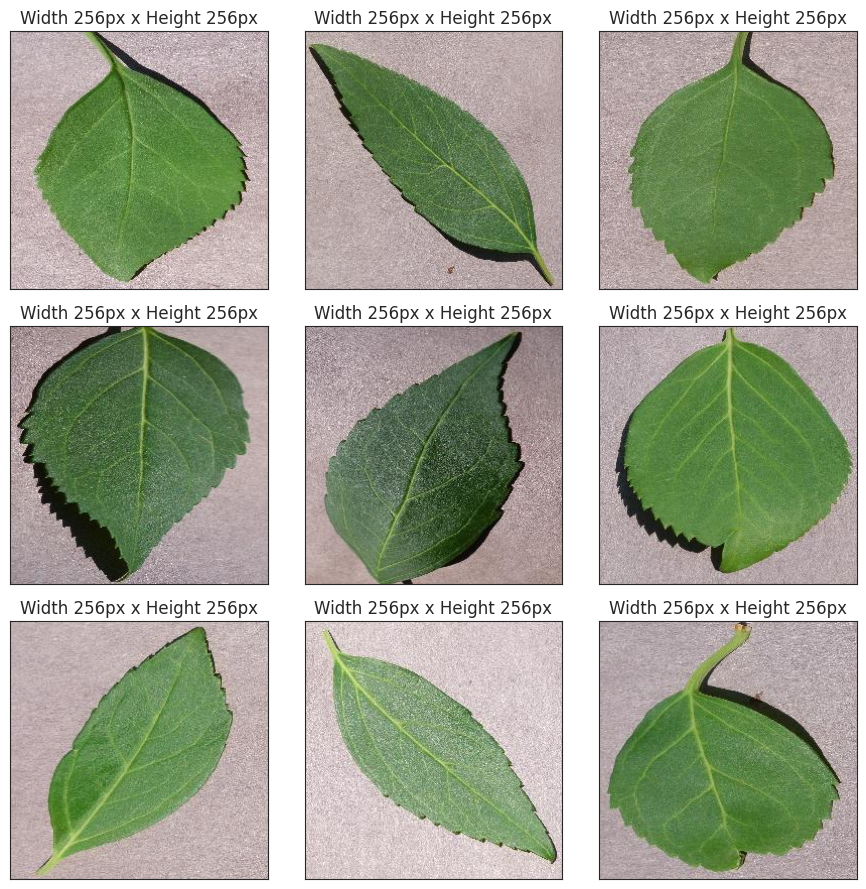



powdery_mildew


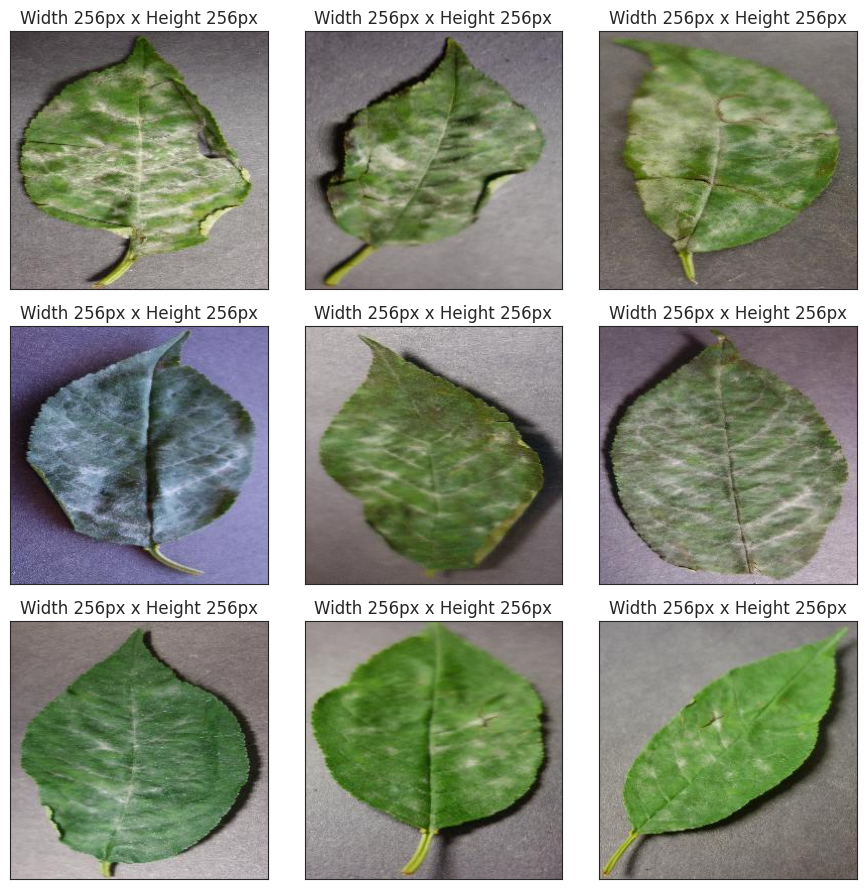

In [18]:
for label in labels:
    print(label)
    image_montage(dir_path=val_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(9, 9)
                  )
    print("\n")

---

## Conclusions and Next Steps

From the analysis, it can be concluded:

1. Healthy Cherry leaves have a more consistent green colour and are crisp in shape.
2. Infected Cherry leaves display clear signs of the powdery mildew and many have a more curled shape.
